# Problem Formulaion

**Define the problem**

* This is a binary classification Task based on the graph data
* The chemical substance can be either positive or negative (0,1)
* Our goal is to use the molecular structure of a chemical substance to predict its anticancer activity

**Input**

The data is represented in the form of a graph that(compound's chemical structure),each sample includes information on the atoms and the connections between them which are the inputs.

**Output**

the prediction of the anticancer activity of a chemical compound using the chemical structure of the compound (0,1). 

**Data mining function is required**

1.Generalization and Summarization

2.Association and Correlation

3.Clustering

4.Outlier/Anomaly Analysis

5.Classification & Prediction

5.Time and Ordering 

6.Structure and Network Analysis

**The data mining in this problem requires Classification After preprocess the data by:**

* Import libraries -> to help in dealing with things as preprocessing and build the models etc...
* Load the data -> make a prediction of
virtualizing the data and find any pattern or information

* Data preprocessing -> Characters such as ['O','N','C',....] are used to represent nodes or atoms. it's viewed as a sequence of text data,using tokenization on the data.
* Balance the data -> the probability of the output class is calculated using a graph convolutional network. we implement using:

demo method
GGNN Method
RGCN Method
RGAT Method
GNN-FILM Method

**Challenges**

* dealing with sdf file format
* making resampling
* improve the perormance of the models
* find the best model architecture with the best hyperparameters 
* the runtime
* avoid undefitting & overfitting  

**Impact**

it could assist to predict the anticancer activity of a chemical compound using the chemical structure of the compound.

**Ideal solution**

The ideal on we did it was the RCGN in the second trail

it gives 85% on auc in test(kaggle)  

**Experimental protocol used and how was it carried out**


* first, is to read the sdf file to obtain information about the atoms in the molecule and their connectivity. The atoms are nodes, and the connections are the edges. 

* Characters (as ['O','N','C']) are used to represent nodes (atoms), it's viewed as a sequence of text data, with the best method to characterise it being to tokenize the data.

* the probability of the output class is calculated using a graph convolutional network. Message passing methods are implemented differently in different approaches, such as:

GGNN : means Gated Graph Neural Networks

RGCN : (Graph convolution layers)

RGAT : Relational Graph Attention Networks

GNN-Film : new Graph Neural Network (GNN) type using feature-wise linear modulation (FiLM)

**How did we tune hyper-parameters in the template**

We tried multiple hyperparameters manually and compare the score to find the best ones

Here, we use those hyperparameters:

message_calculation_class

hidden_dim

num_aggr_MLP_hidden_layers

dense_every_num_layers

num_heads

num_layers

num_edge_MLP_hidden_layers

film_parameter_MLP_hidden_layers

**What is the search space and what is the criteria to determine good/bad hyper-parameters**

The search space was in hyperparameters of GNN layer.


Search space describes the set of possible neural network architectures. These search spaces are designed specific to the application.

There are basically four methods to determine hyperparameters:

* manual Search: Using knowledge you have about the problem guess parameters and observe the result.

* Grid Search: Train your network with every possible parameter combination and pick the one that works best. 

* Random Search:Train your network with random parameter and pick the best in this random one .

* Bayesian Optimization:deciding how to alter the hyper parameters for the next experiment based on the knowledge acquired from any specific experiment. 

The criteria that used is determine the performance with val loss and auc of the validation sets.


#Explain your understanding (based on the documentation/paper) of the mechanisms you chose.

* GGNN : Gated Graph Neural Networks (GG-NNs) with Gated Graphs unroll recurrence for a known number of steps and use optimization approaches to backpropagate 

* RGAT : Relational Graph Attention Networks Compute new graph states using attention and neural message passing.

* RGCN : (Graph Convolutional Networks) is extended by Relational Graph Convolutional Networks (RGCN),compute new graph states by neural message passing , GCN's layers are a generalisation of convolutional layers in a CNN, where the data can have a dynamic number of neighbours rather than being set on a grid like pixels in a picture. GCN layers come in a variety of shapes and sizes, with more being introduced 
* GNN-FiLm : new Graph Neural Network (GNN) type using feature-wise linear modulation (FiLM).it represents the target node of an edge is additionally used to compute a transformation that can be applied to all incoming messages, allowing feature-wise modulation of the passed information.



------------



------------



---------







# Lets Start our Codeeeee 😇✍

# Read SDF File 📚

In [ ]:
#method to read sdf file
#molecules are delimited by 

#the atom block lines start with '    ' and have information about atoms(C,O,N,..)
#bond block starts with ' ' and contains info about connection between atoms
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

def read_sdf(file):
  #opening the file
    with open(file, 'r') as rf:
      #reading the file
        content = rf.read()
        #splitting the read file by delimiter 

        #thus splitting each molecule in an array
    samples = content.split('$$$$')

    #method to read each molecule configuration
    #s for each one of molecule
    
    def parse_sample(s):
        #splitting the text data to lines
        lines = s.splitlines()
        #empty array for edges
        links = []
        #empty array for nodes
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            #for Atom block
            if l.startswith('    '):
                feature = l.split()
                #node feature (atom) as O,C etc
                node = feature[3]
                #appending nodes
                nodes.append(node)
                #bonds tell connections between atoms
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
        
        

**Reading the train & test data**

In [ ]:
training_set = read_sdf('/content/train.sdf')

  0%|          | 0/18016 [00:00<?, ?it/s]

In [ ]:
testing_set  = read_sdf('/content/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

**Split the data to train and validate data 🔪**

In [ ]:
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(training_set, test_size=0.2)

## Visualizing/Inspecting a Sample 👀👀👀

Each molecule represented by a training set. 

Three items make up each sample array.

* First part: contains text data on the atoms
* Second part: data about the connections 
* Third part: information about each molecule's label

✒ atoms are known as nodes and the connections are known as edges 

In [ ]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [ ]:
def visualize(sample):
  #initiating an instance of Graph
    G=nx.Graph()
    #all atoms as nodes
    nodes = sample[0]
    #all connections as edges
    edges = sample[1]
    #empty dictionary for labels for the all nodes
    labeldict={}
    #empty array for each node color
    node_color=[]
    for i,n in enumerate(nodes):
      #adding node to the graph each node as (0,1,2,..)
        G.add_node(i)
        #dictionary building with [key,value] as [0:'C']
        labeldict[i]=n
        #color
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        #adding egde to the graph from one connection to other connection
        G.add_edge(e[0], e[1])
    #drawing the graph with labels for nodes as atoms and connections as edges     
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

# Draw on of the samples 🖊🖊🖊

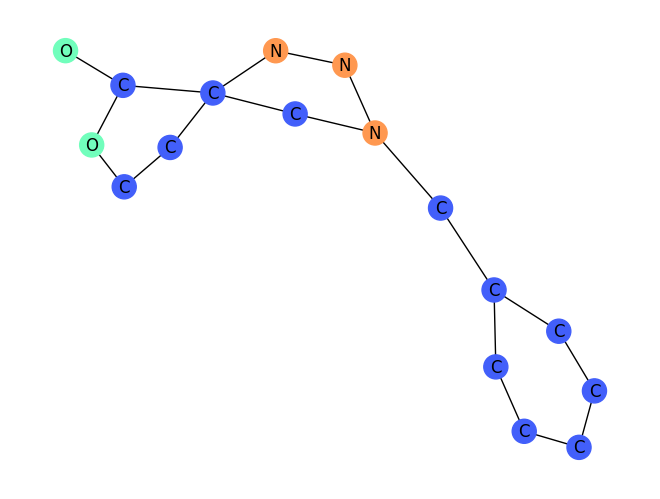

In [ ]:
#displaying one sample
plt.clf()
visualize(training_set[30])

## Preprocessing ⌛

In [ ]:
#checking for data balancing
np.unique(np.array(training_set)[:,2],return_counts=True)

<ipython-input-8-0d212a6350d8>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.unique(np.array(training_set)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([13708,   704]))

In [ ]:
#convert the data from List to DataFrame to make upsampling
data = pd.DataFrame(np.array(training_set)[:,:], columns = ['0', '1', 'target'])

<ipython-input-9-3e969680cc6f>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = pd.DataFrame(np.array(training_set)[:,:], columns = ['0', '1', 'target'])


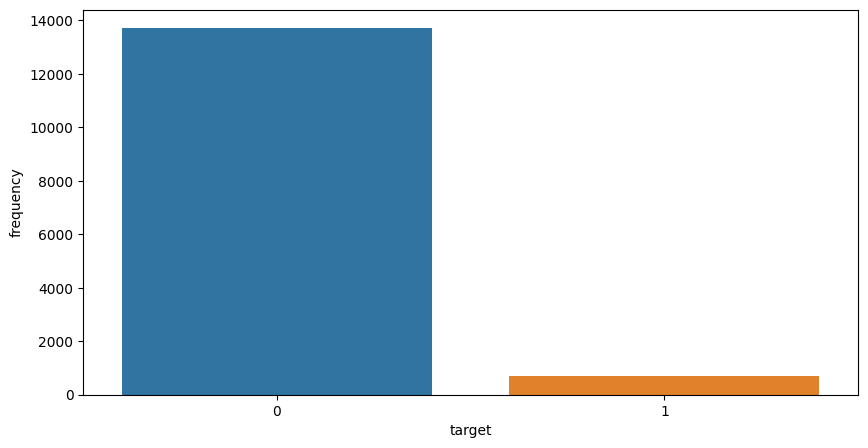

In [ ]:
#checking for the distribution of target data
import matplotlib.pyplot as plt
import seaborn as sns
#checking for the distribution of target data
fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot(x='target', data = data , order = data['target'].value_counts().index, ax = ax )
ax.set(xlabel='target', ylabel='frequency')
plt.show()


## Resample to upsample the data

In [ ]:
#specify the length of the maximum freqent data to make the both labels have the same number of sample
len01 = np.unique(np.array(training_set)[:,2],return_counts=True)[1][0]
len01

<ipython-input-11-17e141e7467a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  len01 = np.unique(np.array(training_set)[:,2],return_counts=True)[1][0]


13708

In [ ]:
from sklearn.utils import resample

resampling = data.copy()  #take a copy of dataframe to make resampling
class0 = resampling[resampling['target']==0]   #specify all rows which has target zero
class1 = resampling[resampling['target']==1]   #specify all rows which has target one
class1aftr = resample(class1, n_samples = len01, replace=True)   #add data records to data frame with value one to make the number of rows which has target 0 == number of rows whic has target 1
d_upsampl = pd.concat([class0, class1aftr])    #add the new rows to the new data frame

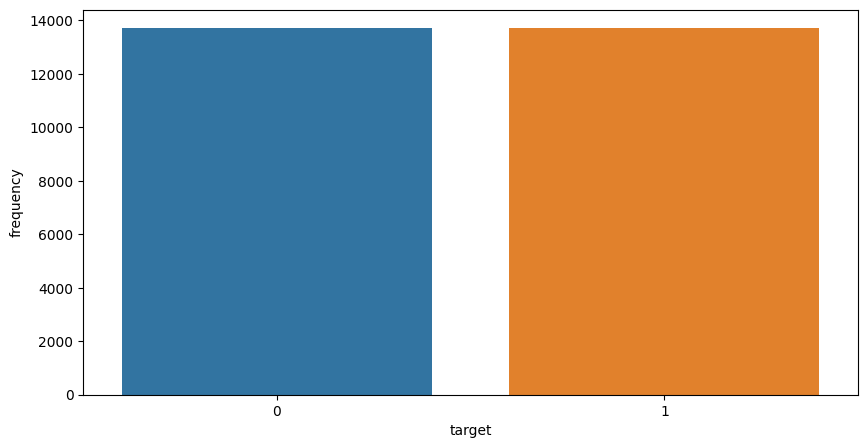

In [ ]:
#checking for the distribution of target data after upsampling
fig, ax = plt.subplots(figsize = (10, 5))
sns.countplot(x='target', data = d_upsampl, order = d_upsampl['target'].value_counts().index, ax = ax)
ax.set(xlabel='target', ylabel='frequency')
plt.show()

In [ ]:
# Here, converting the upsampled DataFrame into list again to be able to use the preprocessing methods on it
training_set = d_upsampl.values.tolist()

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
#vocabulary size
max_vocab = 50
# maximum length of the tokenized vector
max_len = 1000


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]

#training tokenizer
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

1. method to prepare single batch set

2. samples represents the batch of data

3. build a _preprocess function which assign integer value to each word in the sequence based on vocab
4. then transform into a matrix using pad_sequences from keras with

5. vocab_size = 50 ,max_len = 1000 ,padding = post

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    #nodes characters array
    sample_nodes = [s[0] for s in samples]
    #tokenizing the sample nodes
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    #pad_sequences for each sample node with post padding
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    #maximum length of nodes
    max_nodes_len = np.shape(sample_nodes)[1]
    #defining edges
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    #array definition for ids
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    #reshaping as 1 vector
    #concatenating all the edges as size [total_edges ,2]
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    #returns a dictionary of features and label
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])


#generating batch with given btch_size method
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
          #randomly shuffling
          random.shuffle(dataset)
        #length of dataset
        l = len(dataset)
        #for creating batches from given dataset
        for ndx in range(0, l, batch_size):
            #creating batch samples with given batch_size
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            #returning a generator with prepared batches
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 5 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
edges
[[  0  13]
 [  0  20]
 [  1  16]
 [  1  25]
 [  2  13]
 [  3  19]
 [  3  30]
 [  4  18]
 [  5  22]
 [  6  23]
 [  6  32]
 [  7  25]
 [  8  27]
 [  9  30]
 [ 10  32]
 [ 11  12]
 [ 11  15]
 [ 11  16]
 [ 11  20]
 [ 12  13]
 [ 12  14]
 [ 13  18]
 [ 14  17]
 [ 14  22]
 [ 14  26]
 [ 15  21]
 [ 15  23]
 [ 16  19]
 [ 17  19]
 [ 17  24]
 [ 18  21]
 [ 21  29]
 [ 22  27]
 [ 23  25]
 [ 24  28]
 [ 24  31]
 [ 27  28]
 [ 30  33]
 [ 32  34]
 [ 33  35]
 [ 33  36]
 [ 35  37]
 [ 38  48]
 [ 39  47]
 [ 40  51]
 [ 41  55]
 [ 41  59]
 [ 42  55]
 [ 43  47]
 [ 43  49]
 [ 43  50]
 [ 44  47]
 [ 44  48]
 [ 44  54]
 [ 45  51]
 [ 45  55]
 [ 46  48]
 [ 46  49]
 [ 46  51]
 [ 50  52]
 [ 50  53]
 [ 52  5

In [ ]:
!pip install --quiet tf2_gnn
from tf2_gnn.layers.gnn import GNN, GNNInput

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam



---



---



---



To understand the dimension
* we assume that the batch contains 10 samples of data.
* the nodes are tokenized using 44 dimension array that is each sample node is of shape [44] Thus 10 samples are of shape [440]
* after applying get_batch method node2graph is also of shape [440] like [0,0,0,0,0,...,1,1,1,1,....2,2,2,....] each number is repeated 44 times [0,0,0,0,... 44 times] 

* we assume that edges are of size [257,2]

The GNN layer takes a GNNInput named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.



#**Lets start our trails 🤭🙌**

# First Trial (Demo)

In this trial we will use the demo on the balanced data to see the results and our expectation to get good results

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 40
#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)
#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(avg)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

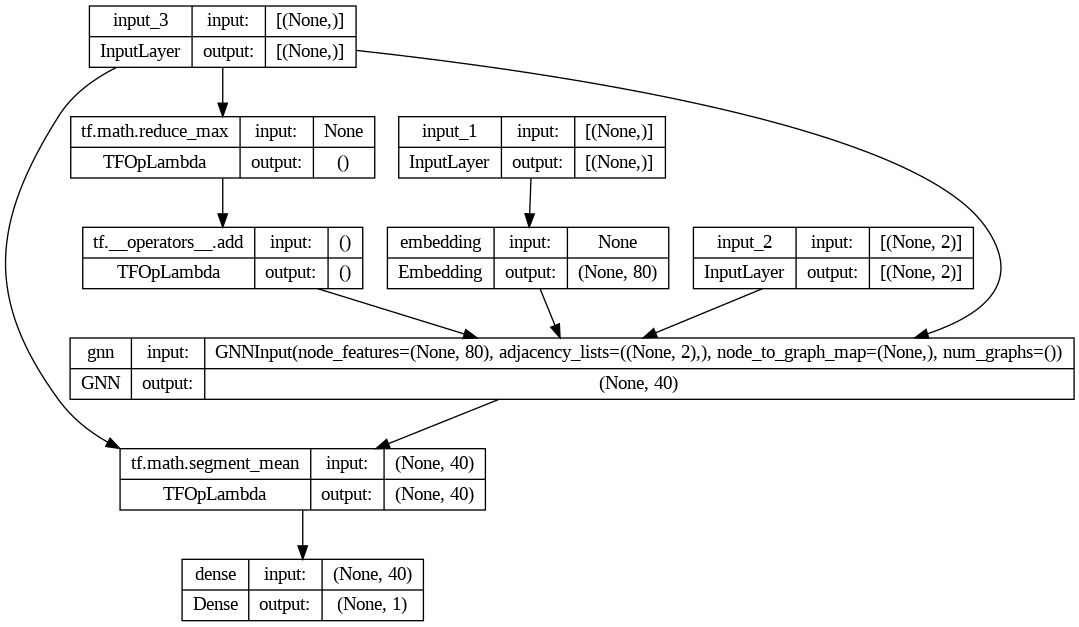

In [ ]:
# to print the architecture
tf.keras.utils.plot_model(model, show_shapes=True)

Compile the model

Here, we expect to get auc score around 79% for training and get 75% for validation

In [ ]:
# We just try something new with new learning rate and epsilon
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001,
    epsilon=1e-07)
)

In [ ]:
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/30
857/857 [==============================] - 63s 68ms/step - loss: 0.6299 - auc: 0.7021 - val_loss: 0.5937 - val_auc: 0.7437
Epoch 2/30
857/857 [==============================] - 34s 40ms/step - loss: 0.5996 - auc: 0.7371 - val_loss: 0.6523 - val_auc: 0.7453
Epoch 3/30
857/857 [==============================] - 36s 42ms/step - loss: 0.5909 - auc: 0.7471 - val_loss: 0.7024 - val_auc: 0.7428
Epoch 4/30
857/857 [==============================] - 39s 45ms/step - loss: 0.5712 - auc: 0.7675 - val_loss: 0.6774 - val_auc: 0.7561
Epoch 5/30
857/857 [==============================] - 36s 42ms/step - loss: 0.5597 - auc: 0.7805 - val_loss: 0.5542 - val_auc: 0.7887
Epoch 6/30
857/857 [==============================] - 35s 41ms/step - loss: 0.5435 - auc: 0.7980 - val_loss: 0.5932 - val_auc: 0.7838
Epoch 7/30
857/857 [==============================] - 37s 43ms/step - loss: 0.5281 - auc: 0.8129 - val_loss: 0.7156 - val_auc: 0.7777
Epoch 8/30
857/857 [==============================] - 39s 46ms

In [ ]:
#make a prediction by using the model
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 8s 9ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission.csv')

**The validation AUC :0.78**

**The AUC :0.92**

**The prediction on kaggle :0.77**

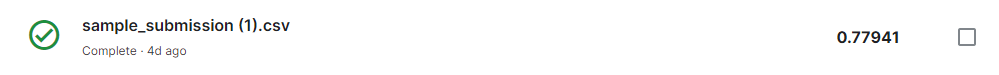

This model does not fit our expectations 😞😞😞😞

# Second Trial (GGNN)

In this trial we will use the GGNN on the balanced data to see the results and our expectation to get better results than the demo

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the ggnn layer
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["dense_every_num_layers"] = 1
params["num_heads"] = 8
params["num_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 2
params["film_parameter_MLP_hidden_layers"] = 1
#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

f1 = Dense(128,activation='relu')(avg)
f2 = Dense(64,activation='relu')(f1)

#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(f2)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model1 = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model1.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

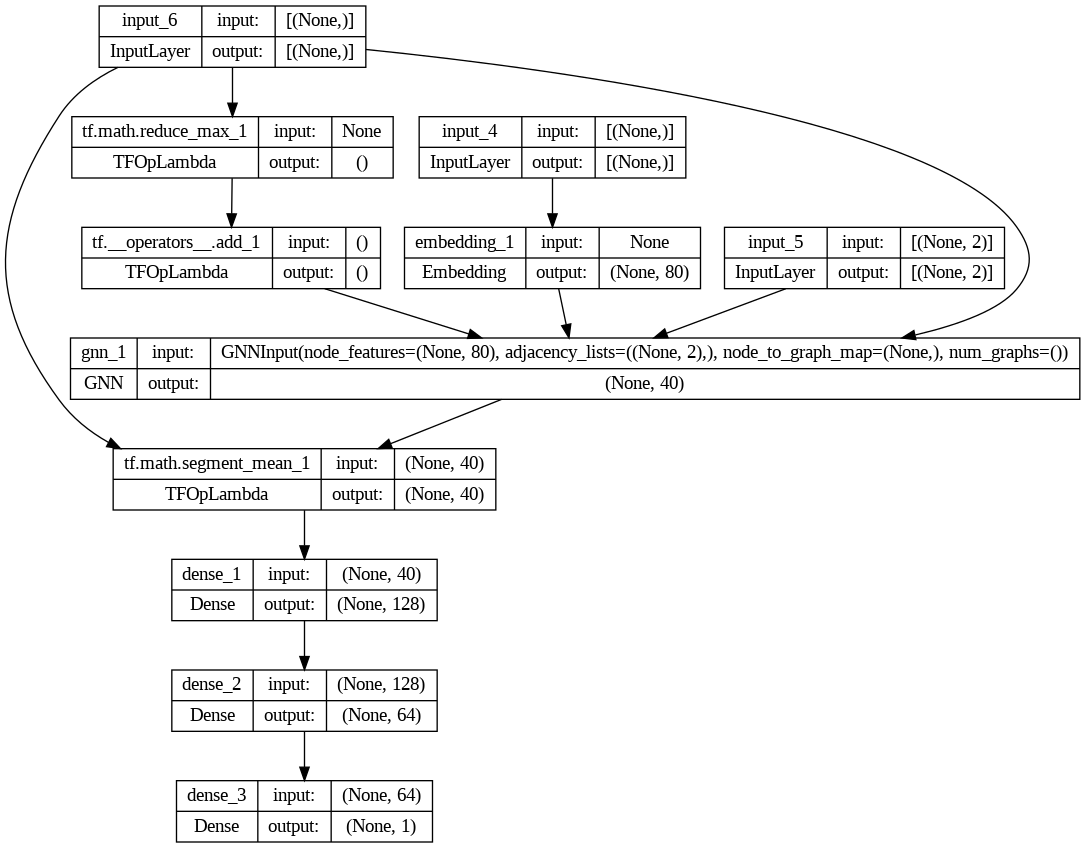

In [ ]:
# to build the archicture
tf.keras.utils.plot_model(model1, show_shapes=True)

**Compile of this model**

Here, we expect to get auc score around 85% for training and get 80% for validation 

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model1.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer = 'adam'
)

In [ ]:
import math

batch_size = 64
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model1.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/15
429/429 [==============================] - 83s 194ms/step - loss: 0.3045 - auc: 0.9397 - val_loss: 0.4750 - val_auc: 0.8262
Epoch 2/15
429/429 [==============================] - 77s 178ms/step - loss: 0.2937 - auc: 0.9439 - val_loss: 0.5077 - val_auc: 0.8150
Epoch 3/15
429/429 [==============================] - 70s 163ms/step - loss: 0.2730 - auc: 0.9510 - val_loss: 0.4872 - val_auc: 0.8071
Epoch 4/15
429/429 [==============================] - 68s 158ms/step - loss: 0.2689 - auc: 0.9522 - val_loss: 0.4999 - val_auc: 0.7839
Epoch 5/15
429/429 [==============================] - 69s 162ms/step - loss: 0.2559 - auc: 0.9565 - val_loss: 0.4879 - val_auc: 0.8204
Epoch 6/15
429/429 [==============================] - 66s 155ms/step - loss: 0.2534 - auc: 0.9569 - val_loss: 0.4324 - val_auc: 0.8244
Epoch 7/15
429/429 [==============================] - 66s 155ms/step - loss: 0.2489 - auc: 0.9590 - val_loss: 0.3854 - val_auc: 0.8197
Epoch 8/15
429/429 [==============================] - 7

In [ ]:
#make a prediction by using the model
y_pred1 = model1.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred1 = np.reshape(y_pred1, -1)

386/386 [==============================] - 10s 25ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred1})
submission.index.name = 'id'
submission.to_csv('sample_submission_GGNN.csv')

**The validation AUC :0.79**

**The AUC :0.97**

**The prediction on kaggle :0.82**

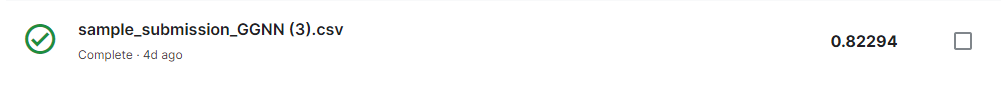

This trail gives better auc than the demo but it has a great overfit 😧😧😧😧

it does not fit the expectations 

# Third Trial (RGAT)

In this trial we will use the RGAT on the balanced data to see the results and our expectation to get better results than GGNN

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the rgat layer
params["message_calculation_class"] = 'RGAT'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["dense_every_num_layers"] = 1
params["num_heads"] = 8
params["num_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 2
params["film_parameter_MLP_hidden_layers"] = 1
#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

f1 = Dense(128,activation='relu')(avg)
f2 = Dense(64,activation='relu')(f1)

#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(f2)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model2 = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model2.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

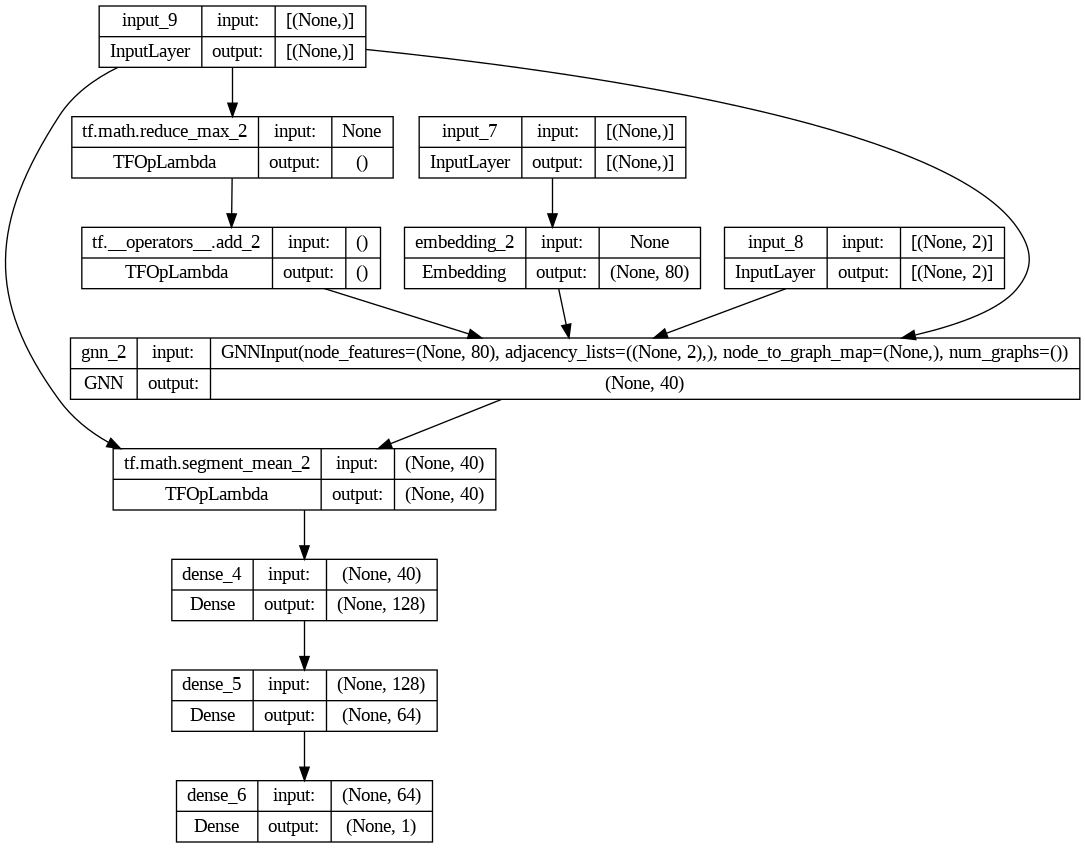

In [ ]:
# the archicture of the model
tf.keras.utils.plot_model(model2, show_shapes=True)

**Compile of this model**

Here, we expect to get auc score around 90% for training and get 80% for validation 

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model2.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer = 'adam'
)

In [ ]:
import math

batch_size = 64
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/15
429/429 [==============================] - 69s 134ms/step - loss: 0.6354 - auc: 0.6879 - val_loss: 0.6892 - val_auc: 0.7661
Epoch 2/15
429/429 [==============================] - 56s 131ms/step - loss: 0.5951 - auc: 0.7422 - val_loss: 0.6641 - val_auc: 0.7477
Epoch 3/15
429/429 [==============================] - 58s 136ms/step - loss: 0.5786 - auc: 0.7635 - val_loss: 0.6921 - val_auc: 0.7599
Epoch 4/15
429/429 [==============================] - 57s 132ms/step - loss: 0.5596 - auc: 0.7848 - val_loss: 0.6518 - val_auc: 0.7729
Epoch 5/15
429/429 [==============================] - 56s 131ms/step - loss: 0.5352 - auc: 0.8085 - val_loss: 0.6667 - val_auc: 0.7747
Epoch 6/15
429/429 [==============================] - 58s 135ms/step - loss: 0.5073 - auc: 0.8311 - val_loss: 0.5286 - val_auc: 0.7930
Epoch 7/15
429/429 [==============================] - 57s 133ms/step - loss: 0.4866 - auc: 0.8464 - val_loss: 0.6825 - val_auc: 0.8187
Epoch 8/15
429/429 [==============================] - 5

In [ ]:
#make a prediction by using the model
y_pred2 = model2.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred2 = np.reshape(y_pred2, -1)

386/386 [==============================] - 10s 24ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred2})
submission.index.name = 'id'
submission.to_csv('sample_submission_RGAT.csv')

**The validation AUC :0.81**

**The AUC :0.92**

**The prediction on kaggle :0.82**

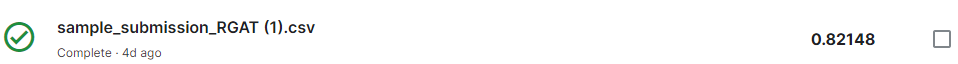

This model almost fit my expectations 🙂🙂🙂🙂

This model is near to GGNN

## Fourth Trial (GNN-FiLM)

In this trial we will use the GNNFilm on the balanced data to see the results and our expectation to get better results than RGAT

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the ggnn layer
params["message_calculation_class"] = 'GNN_FiLM'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["dense_every_num_layers"] = 1
params["num_heads"] = 8
params["num_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 2
params["film_parameter_MLP_hidden_layers"] = 1
#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

f1 = Dense(128,activation='relu')(avg)
f2 = Dense(64,activation='relu')(f1)
f3 = Dense(32,activation='relu')(f2)

#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(f3)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model3 = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model3.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_10/Sigmoid:0', description="created by layer 'dense_10'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []      

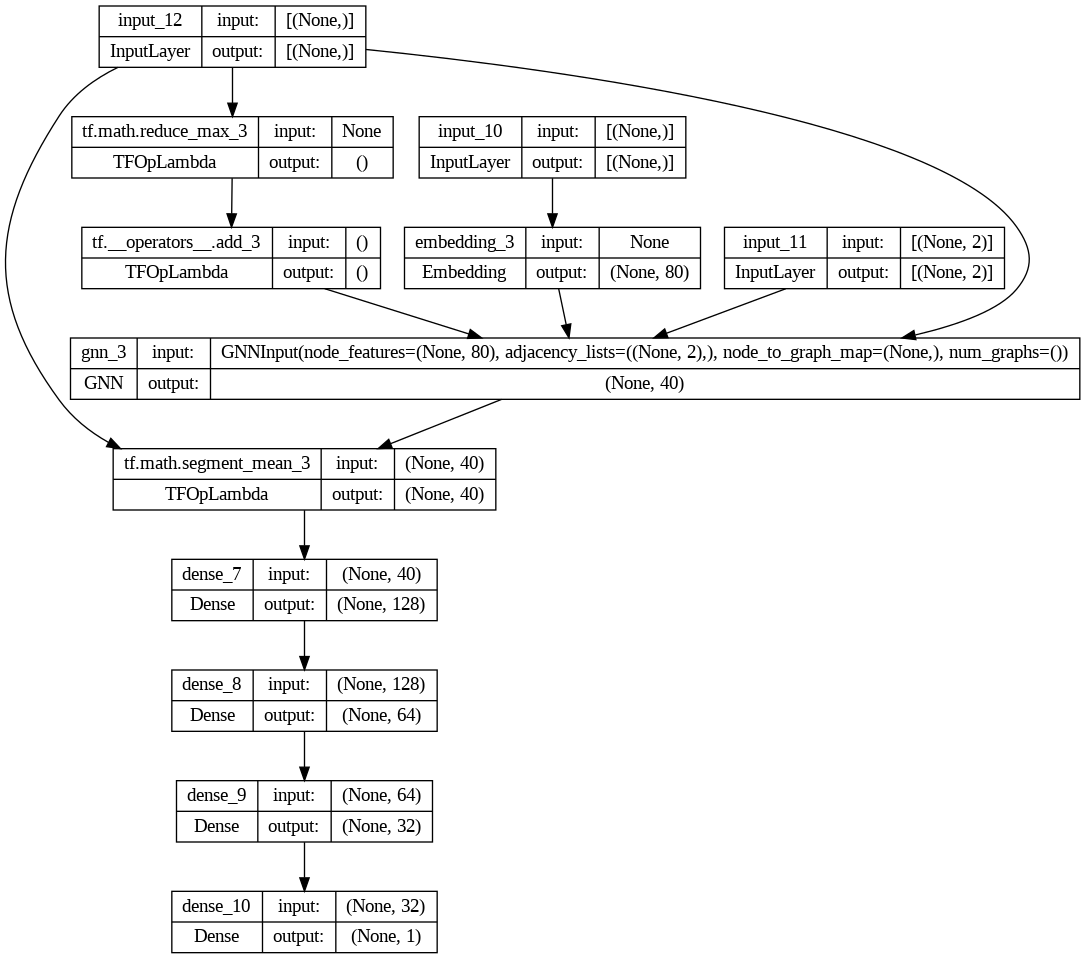

In [ ]:
#the archicture of the model
tf.keras.utils.plot_model(model3, show_shapes=True)

**Compile of the model**

Here, we expect to get auc score around 92% for training and get 85% for validation

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model3.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer = 'adam'
)

In [ ]:
import math

batch_size = 64
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model3.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/15
429/429 [==============================] - 56s 111ms/step - loss: 0.6297 - auc: 0.6916 - val_loss: 0.7157 - val_auc: 0.7353
Epoch 2/15
429/429 [==============================] - 51s 119ms/step - loss: 0.5650 - auc: 0.7773 - val_loss: 0.6583 - val_auc: 0.7970
Epoch 3/15
429/429 [==============================] - 48s 113ms/step - loss: 0.5299 - auc: 0.8130 - val_loss: 0.5898 - val_auc: 0.7727
Epoch 4/15
429/429 [==============================] - 48s 112ms/step - loss: 0.4978 - auc: 0.8388 - val_loss: 0.6530 - val_auc: 0.8024
Epoch 5/15
429/429 [==============================] - 48s 113ms/step - loss: 0.4622 - auc: 0.8621 - val_loss: 0.6823 - val_auc: 0.7707
Epoch 6/15
429/429 [==============================] - 49s 114ms/step - loss: 0.4322 - auc: 0.8804 - val_loss: 0.4817 - val_auc: 0.7905
Epoch 7/15
429/429 [==============================] - 48s 111ms/step - loss: 0.3972 - auc: 0.8994 - val_loss: 0.5714 - val_auc: 0.7693
Epoch 8/15
429/429 [==============================] - 4

In [ ]:
#make a prediction by using the model
y_pred3 = model3.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred3 = np.reshape(y_pred3, -1)

386/386 [==============================] - 7s 16ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred3})
submission.index.name = 'id'
submission.to_csv('sample_submission_GNN_FiLM.csv')

**The validation AUC :0.80**

**The AUC :0.97**

**The prediction on kaggle :0.82**

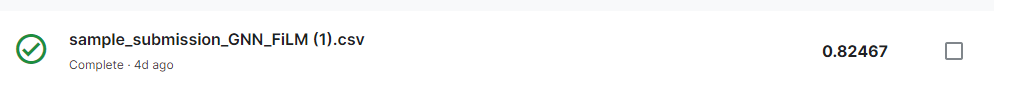

This model is near to my expectations YYYYAYYYYYY 🤭🤭🤭🤭🤭

This model is near to GGNN & RGAT

## Fifth Trial (RGCN)

In this trial we will use the RGCN on the balanced data to see the results and our expectation to get better results

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, Dropout
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the ggnn layer
params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["dense_every_num_layers"] = 1
params["num_heads"] = 8
params["num_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 2
params["film_parameter_MLP_hidden_layers"] = 1
#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

f1 = Dense(128,activation='relu')(avg)
f2 = Dense(64,activation='relu')(f1)
d= Dropout(0.2)(f2)

#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(d)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model4 = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model4.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_13/Sigmoid:0', description="created by layer 'dense_13'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []      

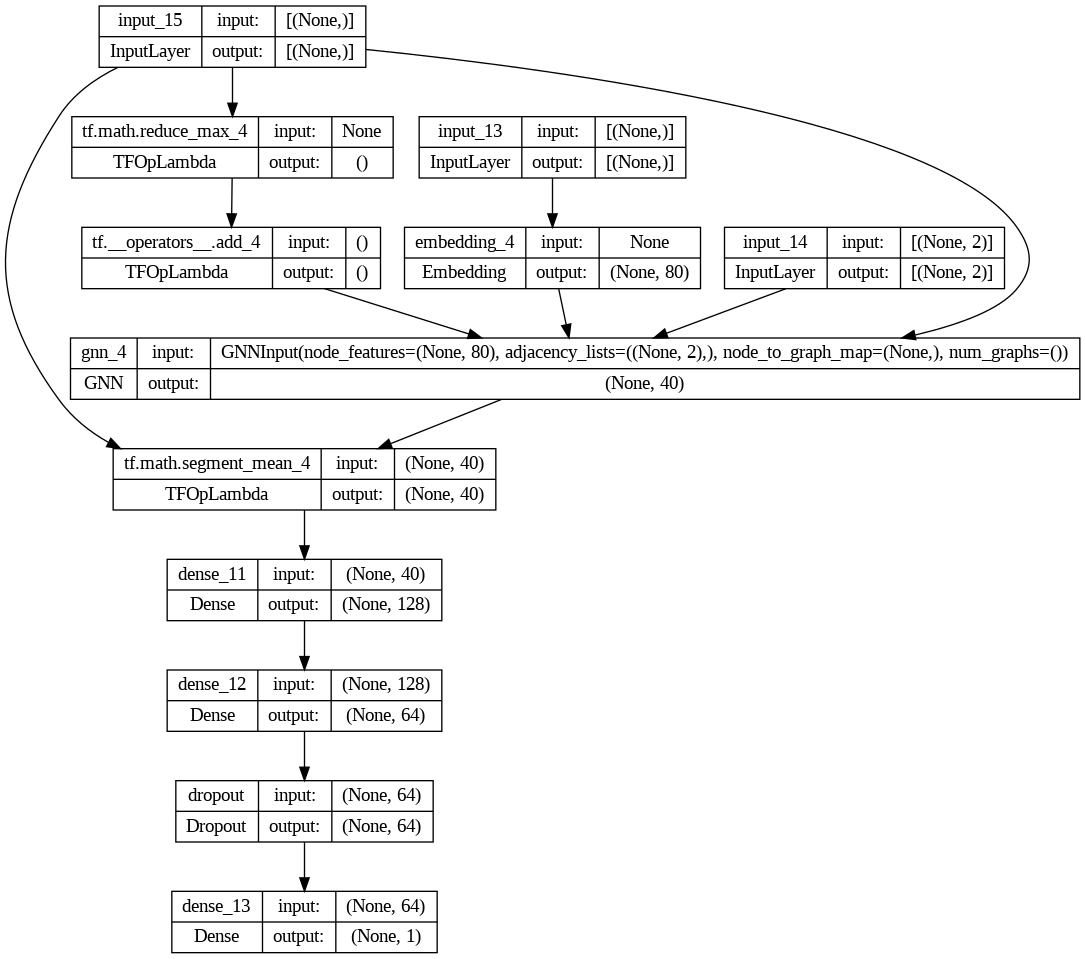

In [ ]:
#the archicture of the model
tf.keras.utils.plot_model(model4, show_shapes=True)

**Compile of the model**

Here, we expect to get auc score around 98% for training and get 90% for validation 

we expected that the this is the best model 

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model4.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer = 'adam'
)

In [ ]:
import math

batch_size = 64
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model4.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/15
429/429 [==============================] - 46s 95ms/step - loss: 0.6365 - auc: 0.6811 - val_loss: 0.7615 - val_auc: 0.7059
Epoch 2/15
429/429 [==============================] - 40s 94ms/step - loss: 0.6000 - auc: 0.7392 - val_loss: 0.7716 - val_auc: 0.8104
Epoch 3/15
429/429 [==============================] - 41s 95ms/step - loss: 0.5878 - auc: 0.7533 - val_loss: 0.8742 - val_auc: 0.7693
Epoch 4/15
429/429 [==============================] - 41s 95ms/step - loss: 0.5783 - auc: 0.7644 - val_loss: 1.0103 - val_auc: 0.7630
Epoch 5/15
429/429 [==============================] - 40s 94ms/step - loss: 0.5708 - auc: 0.7728 - val_loss: 0.7232 - val_auc: 0.7768
Epoch 6/15
429/429 [==============================] - 41s 94ms/step - loss: 0.5708 - auc: 0.7717 - val_loss: 0.8421 - val_auc: 0.7809
Epoch 7/15
429/429 [==============================] - 39s 92ms/step - loss: 0.5522 - auc: 0.7927 - val_loss: 0.7966 - val_auc: 0.7812
Epoch 8/15
429/429 [==============================] - 41s 95ms

In [ ]:
#make a prediction by using the model
y_pred4 = model4.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred4 = np.reshape(y_pred4, -1)

386/386 [==============================] - 7s 17ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred4})
submission.index.name = 'id'
submission.to_csv('sample_submission_RGCN.csv')

**The validation AUC :0.79**

**The AUC :0.85**

**The prediction on kaggle :0.80**

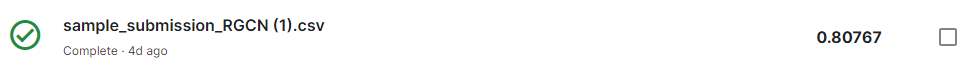

This model does not fit my expectations 😠😠😠😠😠😠

The good in this model that it does not overfit like the rest 


## Sixth Trial (Demo with differenet hyperparameters) to raise the value auc 

Again, in this trial we will use the demo on the balanced data to see the results and our expectation to get better results (here, we change the number of nodes & layers )

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 60)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
params["num_aggr_MLP_hidden_layers"] = 2
params["dense_every_num_layers"] = 1
params["num_heads"] = 8
params["num_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 2
params["film_parameter_MLP_hidden_layers"] = 1

#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)
f1 = Dense(64,activation='relu')(avg)
f2 = Dense(32,activation='relu')(f1)
# d= Dropout(0.2)(f2)

#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(f2)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model5 = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model5.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_16/Sigmoid:0', description="created by layer 'dense_16'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []      

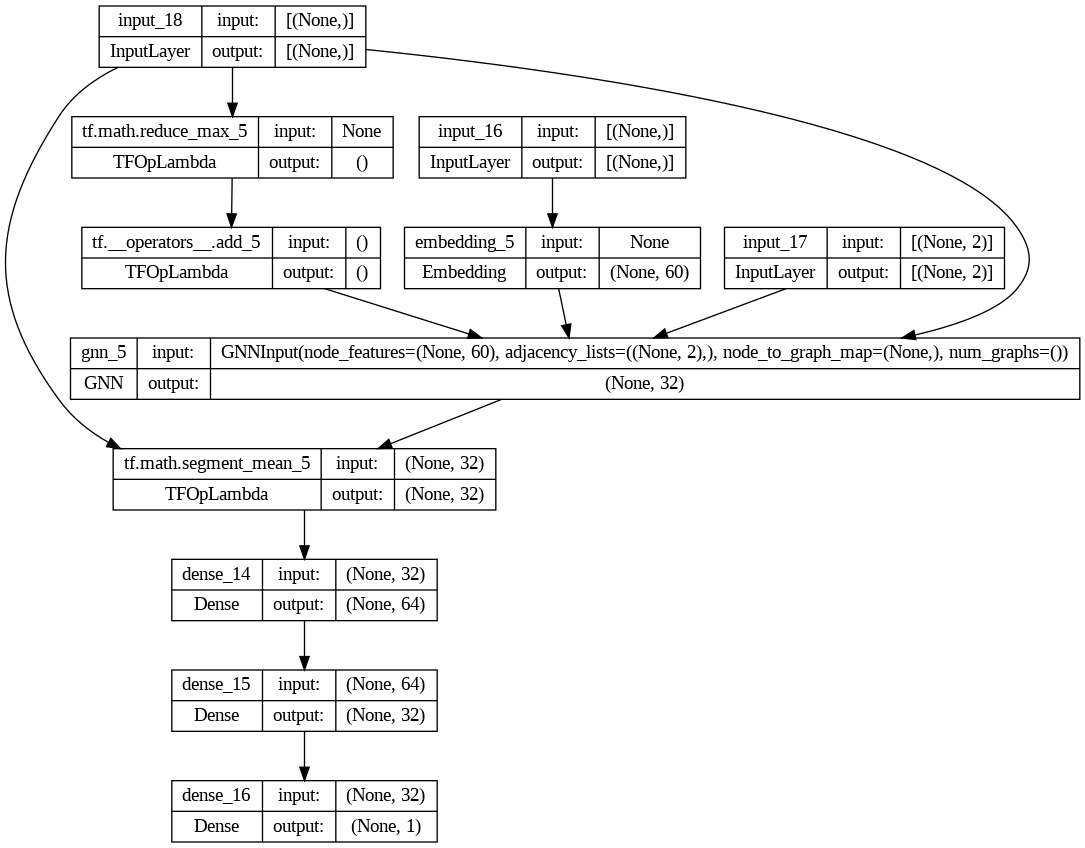

In [ ]:
#the archicture in this model
tf.keras.utils.plot_model(model5, show_shapes=True)

**Compile of the model**

Here, we expect to get auc score around 82% for training and get 79% for validation

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model5.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer = 'adam'
)

In [ ]:
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model4.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/15
857/857 [==============================] - 46s 54ms/step - loss: 0.5062 - auc: 0.8315 - val_loss: 0.7021 - val_auc: 0.7551
Epoch 2/15
857/857 [==============================] - 50s 59ms/step - loss: 0.5285 - auc: 0.8137 - val_loss: 0.5729 - val_auc: 0.7771
Epoch 3/15
857/857 [==============================] - 47s 55ms/step - loss: 0.5083 - auc: 0.8299 - val_loss: 0.5250 - val_auc: 0.7931
Epoch 4/15
857/857 [==============================] - 44s 52ms/step - loss: 0.4920 - auc: 0.8418 - val_loss: 0.5548 - val_auc: 0.7823
Epoch 5/15
857/857 [==============================] - 45s 52ms/step - loss: 0.4794 - auc: 0.8512 - val_loss: 0.5780 - val_auc: 0.7725
Epoch 6/15
857/857 [==============================] - 44s 52ms/step - loss: 0.4639 - auc: 0.8612 - val_loss: 0.5948 - val_auc: 0.7668
Epoch 7/15
857/857 [==============================] - 46s 53ms/step - loss: 0.4544 - auc: 0.8684 - val_loss: 0.5154 - val_auc: 0.7655
Epoch 8/15
857/857 [==============================] - 46s 54ms

In [ ]:
#make a prediction by using the model
y_pred5 = model5.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred5 = np.reshape(y_pred5, -1)

386/386 [==============================] - 6s 14ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred5})
submission.index.name = 'id'
submission.to_csv('sample_submission_demo2.csv')

**The validation AUC :0.76**

**The AUC :0.91**

**The prediction on kaggle :0.62**

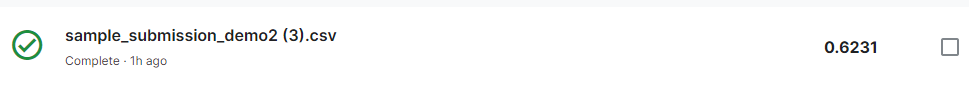

This model does not fit our expectations 😠😠😠😠



## Seventh Trial (GGNN with different hyperparameters) to raise the value auc

Again, in this trial we will use the GGNN on the balanced data to see the results and our expectation to get better results (here, we change the number of nodes & layers )

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 100)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the ggnn layer
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
# params["dense_every_num_layers"] = 1
params["num_heads"] = 8
params["num_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 2
# params["film_parameter_MLP_hidden_layers"] = 1
#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

f1 = Dense(128,activation='relu')(avg)
f2 = Dense(64,activation='relu')(f1)
f3 = Dense(32,activation='relu')(f2)

#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(f3)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model6 = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model6.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_20/Sigmoid:0', description="created by layer 'dense_20'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []      

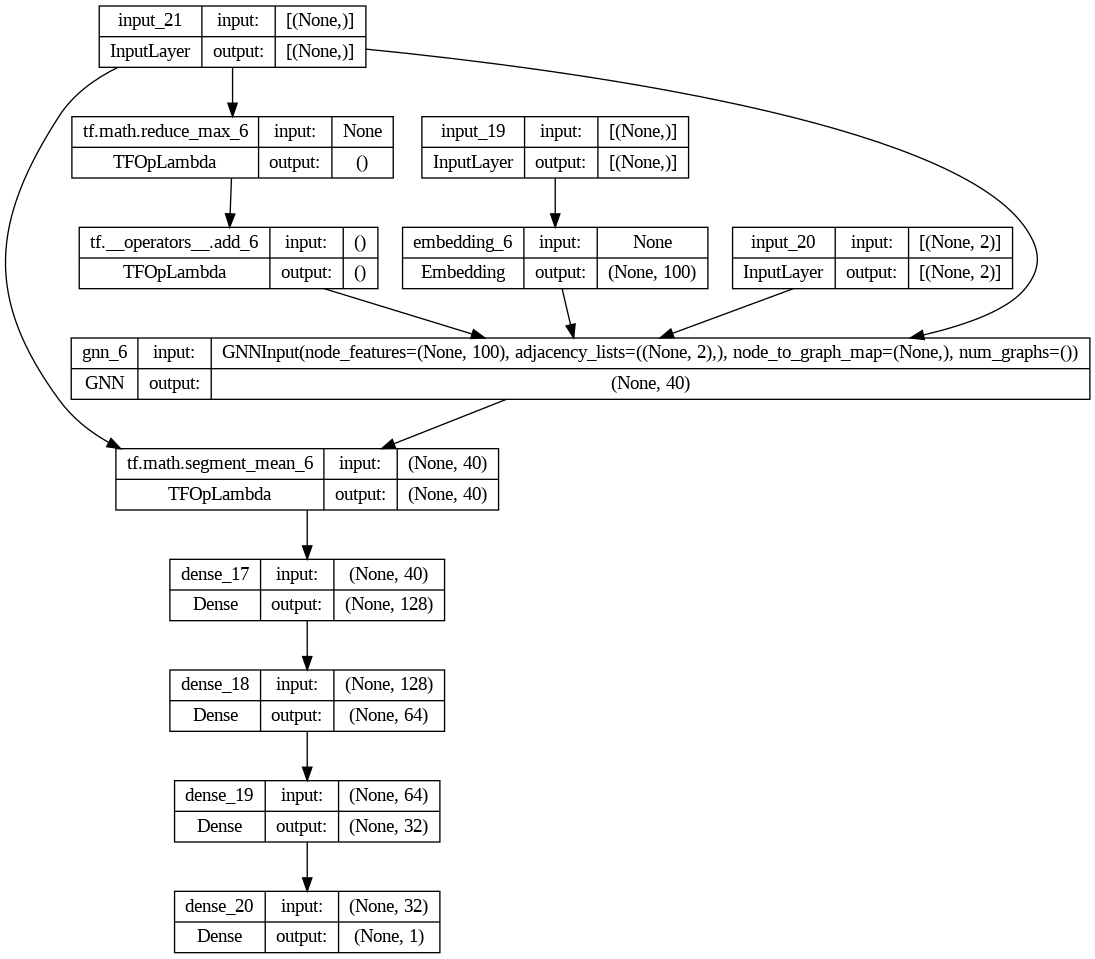

In [ ]:
#the archicture of the model
tf.keras.utils.plot_model(model6, show_shapes=True)

**Compile of the model**

Here, we expect to get auc score around 90% for training and get 85% for validation

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model6.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer = 'adam'
)

In [ ]:
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model6.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/15
857/857 [==============================] - 75s 79ms/step - loss: 0.6288 - auc: 0.6904 - val_loss: 0.7244 - val_auc: 0.7227
Epoch 2/15
857/857 [==============================] - 68s 79ms/step - loss: 0.5987 - auc: 0.7329 - val_loss: 0.6887 - val_auc: 0.7639
Epoch 3/15
857/857 [==============================] - 68s 79ms/step - loss: 0.5747 - auc: 0.7651 - val_loss: 0.6971 - val_auc: 0.7581
Epoch 4/15
857/857 [==============================] - 67s 78ms/step - loss: 0.5289 - auc: 0.8126 - val_loss: 0.5368 - val_auc: 0.8157
Epoch 5/15
857/857 [==============================] - 68s 80ms/step - loss: 0.4824 - auc: 0.8493 - val_loss: 0.6406 - val_auc: 0.8138
Epoch 6/15
857/857 [==============================] - 68s 79ms/step - loss: 0.4550 - auc: 0.8671 - val_loss: 0.7641 - val_auc: 0.7953
Epoch 7/15
857/857 [==============================] - 69s 80ms/step - loss: 0.4505 - auc: 0.8697 - val_loss: 0.4508 - val_auc: 0.8039
Epoch 8/15
857/857 [==============================] - 72s 85ms

In [ ]:
#make a prediction by using the model
y_pred6 = model6.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred6 = np.reshape(y_pred6, -1)

386/386 [==============================] - 11s 26ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred6})
submission.index.name = 'id'
submission.to_csv('sample_submission_GGNN2.csv')

**The validation AUC :0.76**

**The AUC :0.96**

**The prediction on kaggle :0.79**

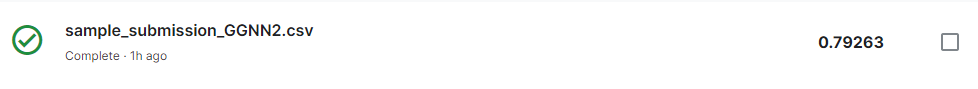

This model gives less auc than the previous GGNN 😞😞😞😞😞😞 

## Eighth Trial (GNN-FiLM with different hyperparameters) to raise the value auc

Again, in this trial we will use the GNNFilm on the balanced data to see the results and our expectation to get better results (here, we change the number of nodes & layers )

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the ggnn layer
params["message_calculation_class"] = 'GNN_FiLM'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["dense_every_num_layers"] = 1
params["num_heads"] = 8
params["num_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 2
params["film_parameter_MLP_hidden_layers"] = 1
#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

f1 = Dense(128,activation='relu')(avg)
f2 = Dense(64,activation='relu')(f1)
# f3 = Dense(32,activation='relu')(f2)

#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(f2)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model7 = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model7.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_7/SegmentMean:0', description="created by layer 'tf.math.segment_mean_7'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_23/Sigmoid:0', description="created by layer 'dense_23'")
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []      

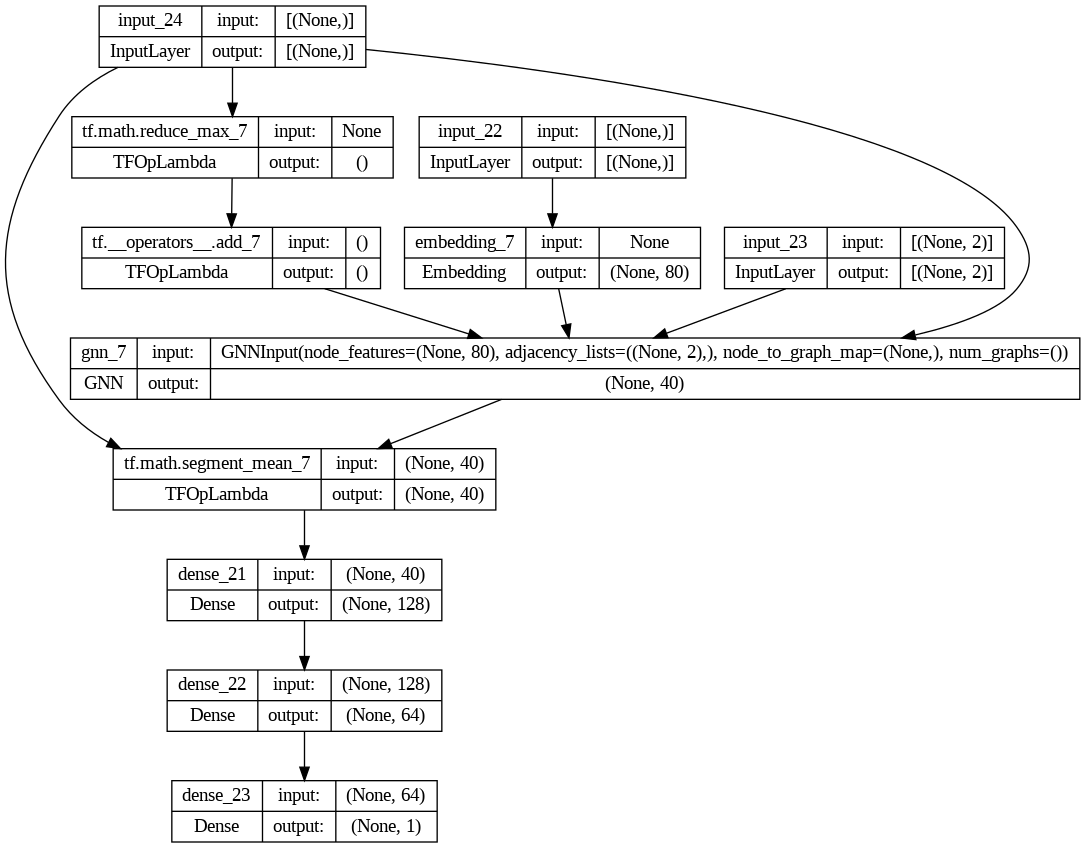

In [ ]:
#the archicture of the model
tf.keras.utils.plot_model(model7, show_shapes=True)

**Compile of this model**

Here, we expect to get auc score around 95% for training and get 90% for validation

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model7.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer = 'adam'
)

In [ ]:
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model7.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/15
857/857 [==============================] - 85s 89ms/step - loss: 0.6175 - auc: 0.7082 - val_loss: 0.5416 - val_auc: 0.7577
Epoch 2/15
857/857 [==============================] - 64s 75ms/step - loss: 0.5530 - auc: 0.7910 - val_loss: 0.4938 - val_auc: 0.7901
Epoch 3/15
857/857 [==============================] - 69s 81ms/step - loss: 0.5178 - auc: 0.8226 - val_loss: 0.6009 - val_auc: 0.7984
Epoch 4/15
857/857 [==============================] - 94s 110ms/step - loss: 0.4913 - auc: 0.8422 - val_loss: 0.5247 - val_auc: 0.8238
Epoch 5/15
857/857 [==============================] - 73s 85ms/step - loss: 0.4662 - auc: 0.8598 - val_loss: 0.4356 - val_auc: 0.8186
Epoch 6/15
857/857 [==============================] - 76s 88ms/step - loss: 0.4327 - auc: 0.8797 - val_loss: 0.5922 - val_auc: 0.8092
Epoch 7/15
857/857 [==============================] - 80s 93ms/step - loss: 0.4100 - auc: 0.8927 - val_loss: 0.3751 - val_auc: 0.8131
Epoch 8/15
857/857 [==============================] - 77s 89m

In [ ]:
#make a prediction by using the model
y_pred7 = model7.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred7 = np.reshape(y_pred7, -1)

386/386 [==============================] - 8s 18ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred7})
submission.index.name = 'id'
submission.to_csv('sample_submission_GNN_FiLM2.csv')

**The validation AUC :0.79**

**The AUC :0.96**

**The prediction on kaggle :0.81**

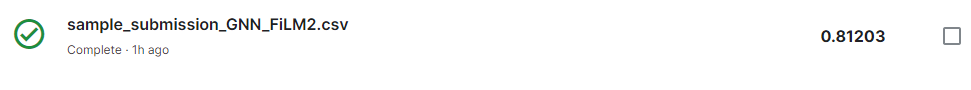

This model is not with big difference than the previous GNN-FiLM 🙂🙂🙂🙂

# Nineth Trial (RGAT with different hyperparameters) to raise the value auc

Again, in this trial we will use the RGAT on the balanced data to see the results and our expectation to get better results (here, we change the number of nodes & layers )

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the ggnn layer
params["message_calculation_class"] = 'RGAT'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["dense_every_num_layers"] = 1
params["num_heads"] = 8
params["num_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 2
params["film_parameter_MLP_hidden_layers"] = 1
#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

f1 = Dense(256,activation='relu')(avg)
f2 = Dense(128,activation='relu')(f1)
f3 = Dense(64,activation='relu')(f2)


#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(f3)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model8 = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model8.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_10/StatefulPartitionedCall:0', description="created by layer 'gnn_10'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_8/SegmentMean:0', description="created by layer 'tf.math.segment_mean_8'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_27/Sigmoid:0', description="created by layer 'dense_27'")
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None,)]            0           []    

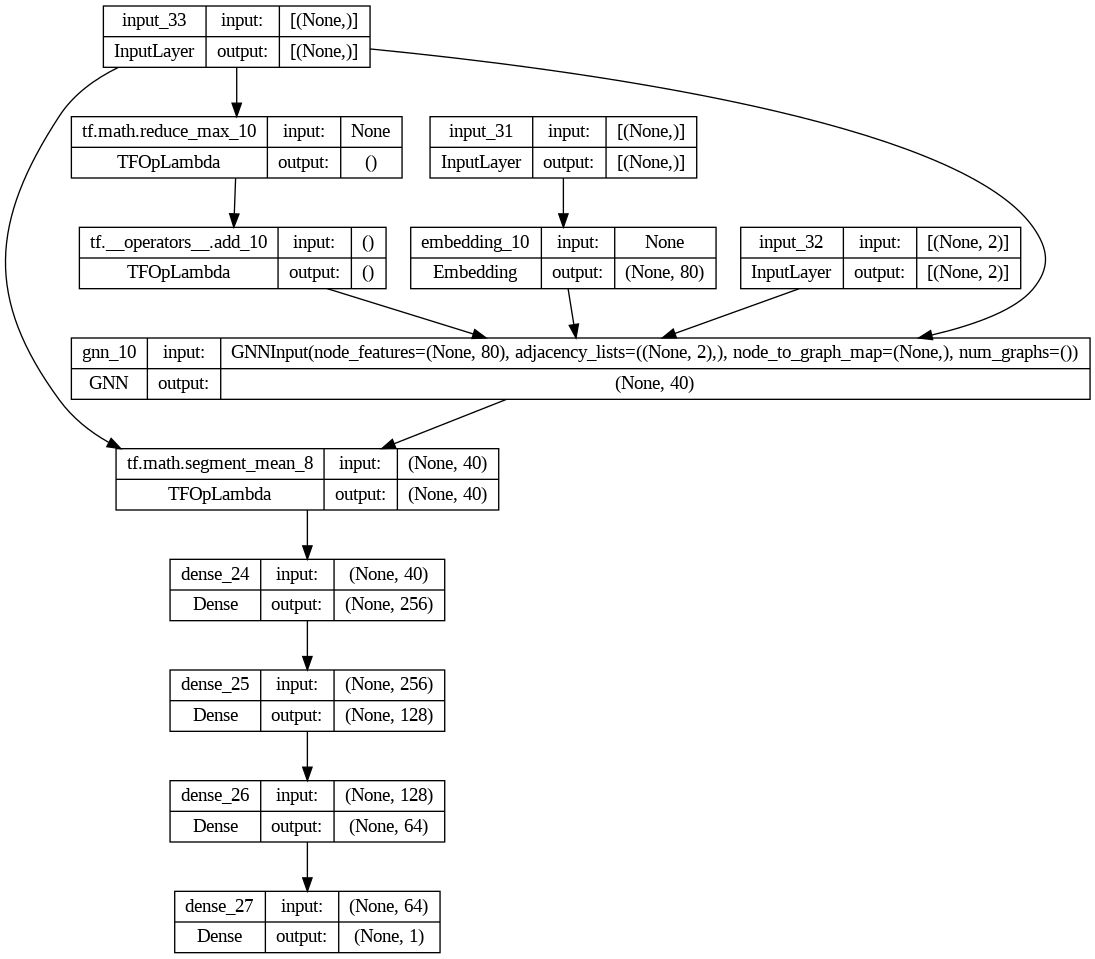

In [ ]:
#the archicture of the model
tf.keras.utils.plot_model(model8, show_shapes=True)

**Compile of the model**

Here, we expect to get auc score around 90% for training and get 85% for validation

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model8.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer = 'adam'
)

In [ ]:
import math

batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model8.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=10,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/10
857/857 [==============================] - 80s 82ms/step - loss: 0.6264 - auc: 0.7008 - val_loss: 0.6348 - val_auc: 0.7490
Epoch 2/10
857/857 [==============================] - 72s 84ms/step - loss: 0.5911 - auc: 0.7483 - val_loss: 0.7291 - val_auc: 0.7593
Epoch 3/10
857/857 [==============================] - 65s 76ms/step - loss: 0.5713 - auc: 0.7718 - val_loss: 0.5927 - val_auc: 0.7667
Epoch 4/10
857/857 [==============================] - 67s 79ms/step - loss: 0.5528 - auc: 0.7920 - val_loss: 0.7337 - val_auc: 0.7684
Epoch 5/10
857/857 [==============================] - 68s 79ms/step - loss: 0.5263 - auc: 0.8157 - val_loss: 0.4595 - val_auc: 0.7914
Epoch 6/10
857/857 [==============================] - 67s 78ms/step - loss: 0.4934 - auc: 0.8412 - val_loss: 0.4231 - val_auc: 0.8052
Epoch 7/10
857/857 [==============================] - 70s 82ms/step - loss: 0.4664 - auc: 0.8600 - val_loss: 0.5889 - val_auc: 0.7743
Epoch 8/10
857/857 [==============================] - 68s 79ms

In [ ]:
#make a prediction by using the model
y_pred8 = model8.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred8 = np.reshape(y_pred8, -1)

386/386 [==============================] - 10s 24ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred8})
submission.index.name = 'id'
submission.to_csv('sample_submission_RGAT2.csv')

**The validation AUC :0.79**

**The AUC :0.90**

**The prediction on kaggle :0.82**

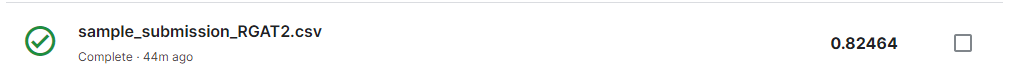

This model almost fit my expecatitions 🙂🙂🙂🙂


it does not differ from the previous RGAT 

## Tenth Trial (RGCN with different hyperparameters) to raise the value auc

Again, in this trial we will use the RGCN on the balanced data to see the results and our expectation to get better results (here, we change the number of nodes & layers )

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, Dropout
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
#Input layer for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input layer for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding layer over data with each token embedded as a vector
embeded = Embedding(tokenizer.num_words, 70)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
#defining hidden dimension of the rgcn layer
params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 40
params["num_aggr_MLP_hidden_layers"] = 2
params["dense_every_num_layers"] = 1
params["num_heads"] = 8
params["num_layers"] = 4
params["num_edge_MLP_hidden_layers"] = 2
params["film_parameter_MLP_hidden_layers"] = 1
#gnn layer with defined hyperparameters
gnn_layer = GNN(params) 
#outpur shape of th output layer: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

fc1 = Dense(256,activation='relu')(avg)
fc2 = Dense(128,activation='relu')(fc1)
fc3 = Dense(64,activation='relu')(fc2)

#final dense layer with sigmoid function
pred = Dense(1, activation='sigmoid')(fc3)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
model9 = Model(
    #inputs is dictionary of data, edges, node2graph
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },#output: prediction value from dense layer
    outputs=pred
)
model9.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_13/StatefulPartitionedCall:0', description="created by layer 'gnn_13'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_11/SegmentMean:0', description="created by layer 'tf.math.segment_mean_11'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_39/Sigmoid:0', description="created by layer 'dense_39'")
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_42 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None,)]            0           [] 

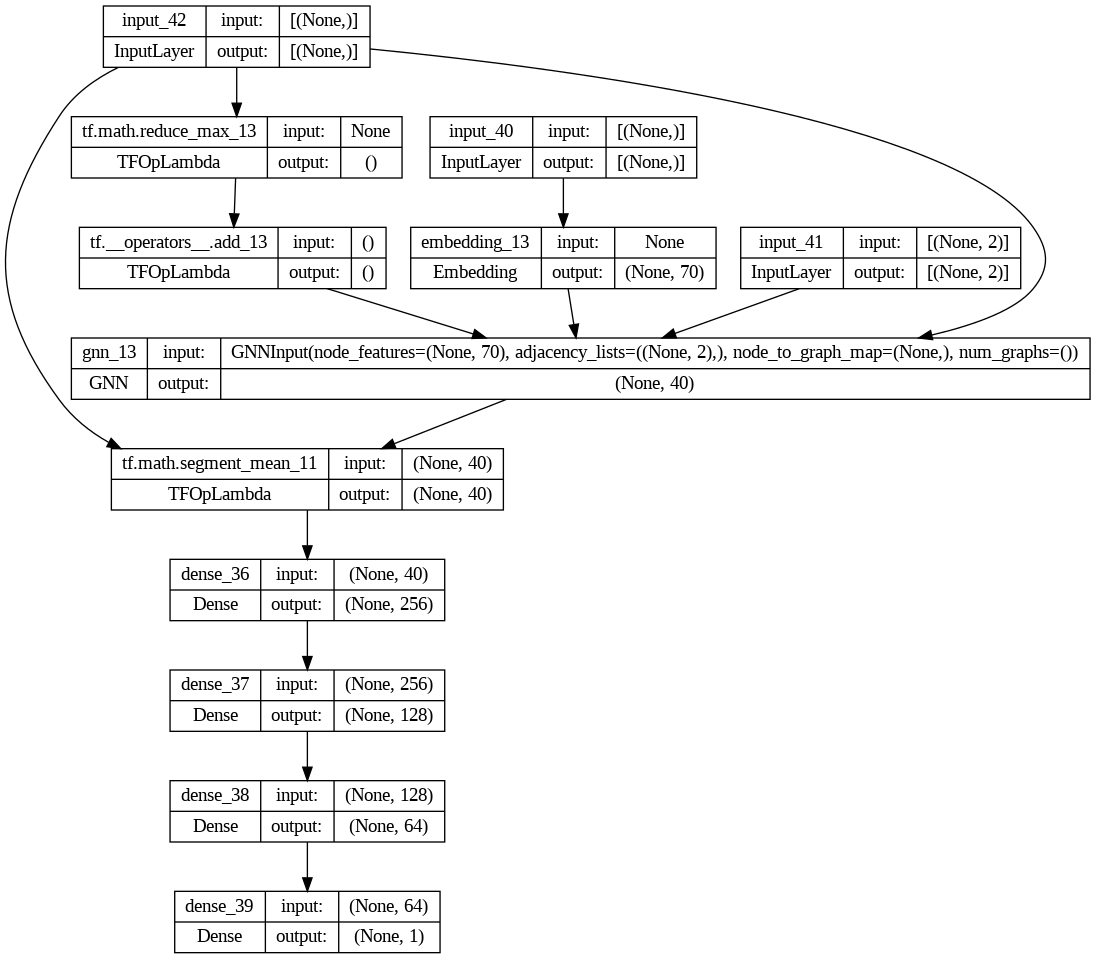

In [ ]:
#the archicture of the model
tf.keras.utils.plot_model(model9, show_shapes=True)

**Compile of the model**

Here, we expect to get auc score around 85% for training and get 75% for validation

we expected that the this is the best model

In [ ]:
#compile the model by using my adam optimizer and BinaryCrossentropy loss
model9.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC'],
    optimizer = 'adam'
)

In [ ]:
import math

batch_size = 64
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

#fit the models with 
model9.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    
)

Epoch 1/15
429/429 [==============================] - 46s 95ms/step - loss: 0.6486 - auc: 0.6531 - val_loss: 0.6413 - val_auc: 0.7537
Epoch 2/15
429/429 [==============================] - 40s 94ms/step - loss: 0.5998 - auc: 0.7353 - val_loss: 0.7940 - val_auc: 0.7224
Epoch 3/15
429/429 [==============================] - 40s 94ms/step - loss: 0.5907 - auc: 0.7486 - val_loss: 0.5707 - val_auc: 0.7897
Epoch 4/15
429/429 [==============================] - 39s 92ms/step - loss: 0.5795 - auc: 0.7613 - val_loss: 0.6280 - val_auc: 0.7254
Epoch 5/15
429/429 [==============================] - 39s 91ms/step - loss: 0.5737 - auc: 0.7688 - val_loss: 0.7402 - val_auc: 0.7785
Epoch 6/15
429/429 [==============================] - 40s 92ms/step - loss: 0.5805 - auc: 0.7591 - val_loss: 0.7159 - val_auc: 0.7511
Epoch 7/15
429/429 [==============================] - 41s 95ms/step - loss: 0.5531 - auc: 0.7891 - val_loss: 0.7470 - val_auc: 0.7698
Epoch 8/15
429/429 [==============================] - 39s 92ms

In [ ]:
#make a prediction by using the model
y_pred9 = model9.predict(
    gen_batch(testing_set, batch_size=32, shuffle=False)
)
y_pred9 = np.reshape(y_pred9, -1)

386/386 [==============================] - 6s 15ms/step


In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred9})
submission.index.name = 'id'
submission.to_csv('sample_submission_RGCN2.csv')

**The validation AUC :0.75**

**The AUC :0.85**

**The prediction on kaggle :0.85**

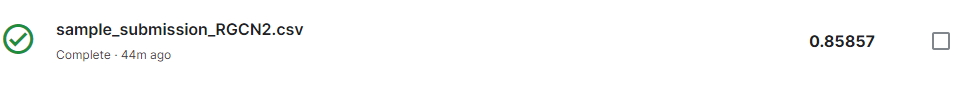

This model fits our expectations 😇😇😇😇😇

This is the best model everrrrrrrrrrrrrr

# Conclusion:

In my opinion, this RCGN suits this problem as it gives high auc on kaggle(testing)

Although, we can use GNN-Film, RGAT & GGNN may give high auc if we play more and more in the architecture (we can not exceed a certain number of layers ,as it takes loooooong time in runtime 😞😞😞😞😞)

# It is time for questions ❓❓❓❓❓❓

**1. Based on the provided template, describe the format of the input file (sdf file)?**

* input file is called data structure file (SDF)
* it has information on a molecule's chemical composition 
* SDF include information about the positions of atom in the molecule & the connections between them

* each molecule begins with a header that describes the compound's title.
* other sections include details on the amount of atoms, connections , version number.
* compound are described in the atom block
* bond block describes the compound's bonding structure
* All these blocks obtain information about the compound and save it as edges and nodes

**2. What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

The input tensors in the network are:

* Data: contains the nodes of the chemical molecule(tokenized form),it tokenized with the tokenizer,then padded with the pad sequence method. (batch_size * max_len_nodes) is the form of each batch(batch_size is the number of samples in the batch & max_len_nodes is the length of tokenized nodes after padding)
* Edge: contains information about atom connections (sum_of_all_edges,2).The batch size is represented by the sum(no. of edges of each sample) of all edges. 

* node2graph:is segmented mean input tensor, which contains information about segmented ids. Each batch has the shape (batch size*max len nodes), batch_size is the number of samples in the batch & max_len_nodes is the length of tokenized nodes after padding

**3. For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

dim of gnn_out: is the shape of the gnn_out, consists of batch_size_node_dimension is dimension of tokenized vector for the complete batch & hidden layer, it represents the model's aggregation output


dim of avg: The segmented mean of the gnn_out is calculated using the segmented ids. The output of gnn_out is tokenized_vector_dimension & hidden_layers for every sample in the batch_size. A segment_id is for every sample, segment_mean represents a sample with a number for each hidden_layer by taking the mean of all the output data in the gnn_out output. The avg tensor's final output is of the shape (batch_size, hidden_layer).

**4. What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

* segment_mean: calculates the average of data with the same segment_ids.

* reduce_mean: computes the mean of elements among the dimensions of a tensor, with given parameters.

* dim of pred: The predicted output indicates whether or not the compound is active against cancer cells or not. (batch_size,1) is the shape of predicted. the final output for each sample is a number that represents association with each compound's activity.

**5. What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

The default template uses the gcn_network's default option for the number of layers. As stated in the documentation, the default layer is 4. rgcn (Graph convolution layers) is the default message passing technique . Using several gcn assists in effectively capturing all graph complexity, as it is better model.

**References**

[link text](https://arxiv.org/pdf/1703.06103.pdf)
[link text](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)
[link text](https://medium.com/analytics-vidhya/paper-series-2-modeling-relational-data-with-graph-convolutional-networks-schlichtkrull-et-al-b009ff48ab87)
[link text](https://github.com/microsoft/tf2-gnn)
[link text](https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py)
[link text](https://arxiv.org/pdf/2107.10015.pdf)
[link text](https://github.com/babylonhealth/rgat)
[link text](https://wellsr.com/python/upsampling-and-downsampling-imbalanced-data-in-python/)
[link text](https://www.tensorflow.org/api_docs/python/tf/math/segment_mean)
[link text](https://jonathan-hui.medium.com/graph-neural-networks-gnn-gae-stgnn-1ac0b5c99550)
[link text](https://www.analyticsvidhya.com/blog/2021/07/how-to-perform-data-visualization-with-pandas/)
[link text](https://www.projectpro.io/recipes/deal-with-imbalance-classes-with-upsampling-in-python)
[link text](https://medium.com/analytics-vidhya/a-review-of-graph-neural-networks-gnn-560be37b8bca)
[link text](https://arxiv.org/abs/1906.12192)